# Solving the Traveling Salesman Problem with TrainSelPy

This notebook demonstrates how to solve the Traveling Salesman Problem (TSP) using the TrainSelPy package. We'll explore both single and multi-objective optimization approaches.

## The Traveling Salesman Problem

The Traveling Salesman Problem is a classic optimization problem: Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

We'll solve the TSP using TrainSelPy's genetic algorithm capabilities, and we'll see how multi-objective optimization can potentially improve the results.

In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from typing import List, Dict, Any
import seaborn as sns

# Import TrainSelPy functions
from trainselpy import (
    make_data, 
    train_sel, 
    train_sel_control
)

## 1. Generate TSP Instance

First, let's generate a random TSP instance. We'll create cities with random coordinates and calculate the distance matrix.

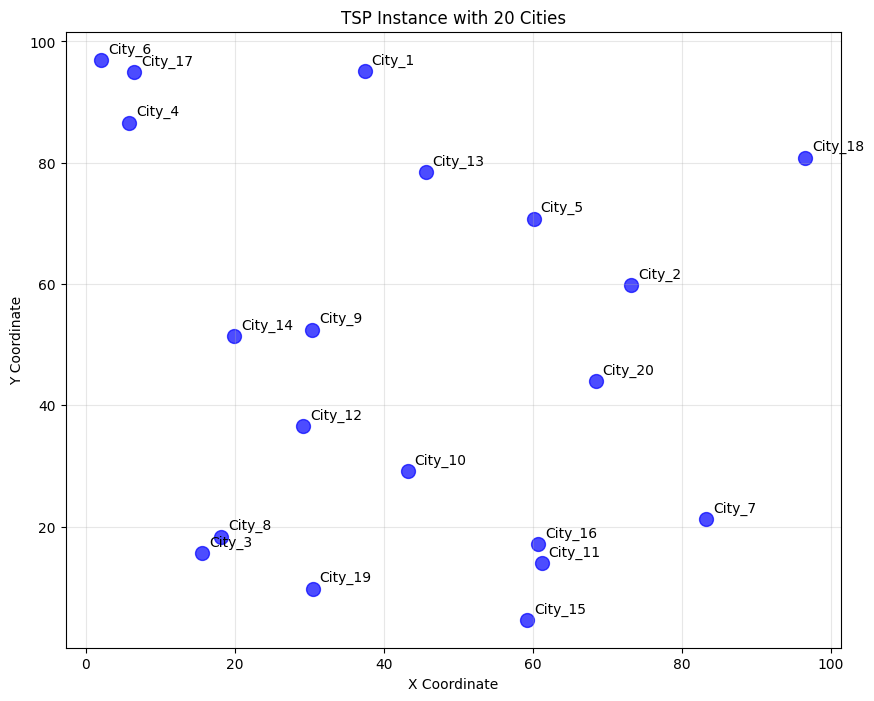

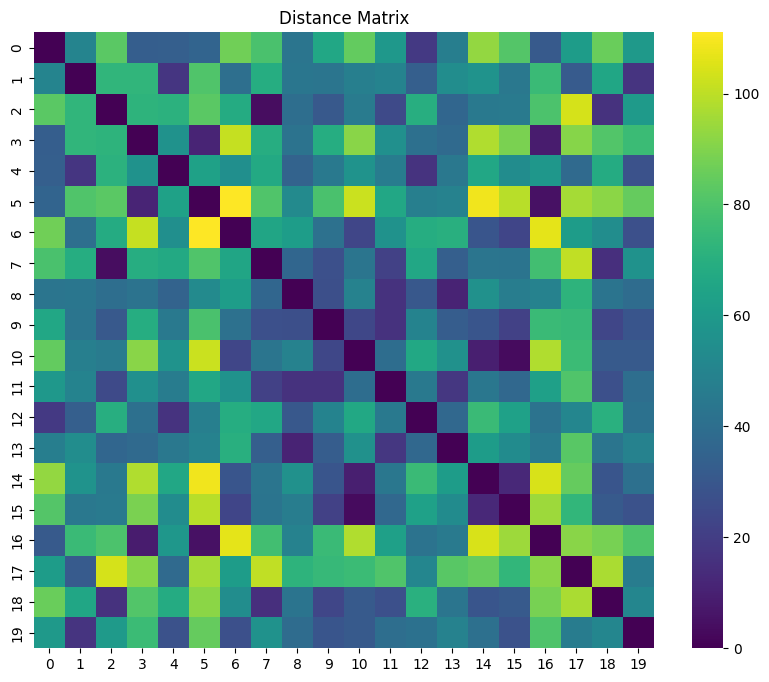

In [8]:
def generate_tsp_instance(n_cities=20, random_seed=42):
    """Generate a random TSP instance with n cities."""
    np.random.seed(random_seed)
    
    # Generate random city locations in a 2D space
    city_coords = np.random.rand(n_cities, 2) * 100
    
    # Calculate distance matrix
    distance_matrix = np.zeros((n_cities, n_cities))
    for i in range(n_cities):
        for j in range(n_cities):
            if i != j:
                # Euclidean distance
                distance_matrix[i, j] = np.sqrt(np.sum((city_coords[i] - city_coords[j])**2))
    
    # Create city names
    city_names = [f"City_{i+1}" for i in range(n_cities)]
    
    return {
        'city_coords': city_coords,
        'distance_matrix': distance_matrix,
        'city_names': city_names
    }

# Generate a random TSP instance
n_cities = 20
tsp_instance = generate_tsp_instance(n_cities)

# Visualize the cities
plt.figure(figsize=(10, 8))
plt.scatter(tsp_instance['city_coords'][:, 0], tsp_instance['city_coords'][:, 1], s=100, c='blue', alpha=0.7)

# Add city labels
for i, (x, y) in enumerate(tsp_instance['city_coords']):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"TSP Instance with {n_cities} Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

# Display distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(tsp_instance['distance_matrix'], annot=False, cmap='viridis')
plt.title("Distance Matrix")
plt.show()

## 2. Define the TSP Evaluation Function

Now we'll define a function to evaluate the total distance of a tour.

Random tour: [14, 18, 3, 12, 7, 15, 0, 8, 17, 1, 5, 19, 13, 6, 11, 10, 16, 9, 2, 4]
Random tour distance: 1207.71


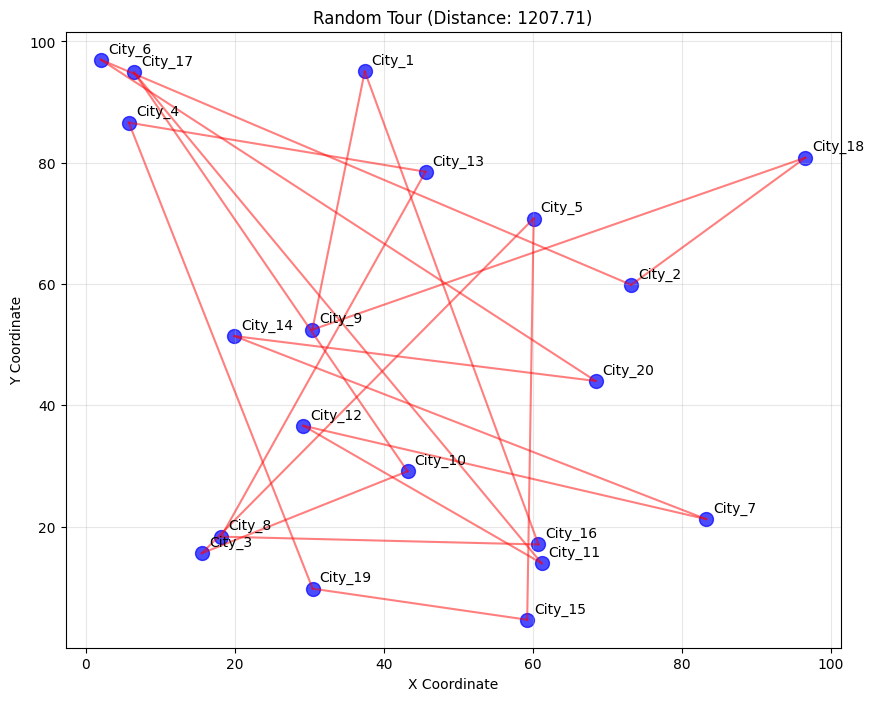

In [9]:
def calculate_tour_distance(tour, distance_matrix):
    """Calculate the total distance of a tour."""
    # Ensure tour is a numpy array
    tour = np.array(tour)
    
    # Calculate total distance
    total_distance = 0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)]  # Wrap around to the first city
        total_distance += distance_matrix[from_city, to_city]
    
    return total_distance

# Create a random tour and calculate its distance
random_tour = list(range(n_cities))
random.shuffle(random_tour)
random_distance = calculate_tour_distance(random_tour, tsp_instance['distance_matrix'])

print(f"Random tour: {random_tour}")
print(f"Random tour distance: {random_distance:.2f}")

# Visualize the random tour
plt.figure(figsize=(10, 8))
coords = tsp_instance['city_coords']

# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], s=100, c='blue', alpha=0.7)

# Plot tour
for i in range(len(random_tour)):
    from_city = random_tour[i]
    to_city = random_tour[(i + 1) % len(random_tour)]
    plt.plot([coords[from_city, 0], coords[to_city, 0]], 
             [coords[from_city, 1], coords[to_city, 1]], 'r-', alpha=0.5)

# Add city labels
for i, (x, y) in enumerate(coords):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"Random Tour (Distance: {random_distance:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

## 3. Single-Objective TSP Optimization

First, let's solve the TSP using a single objective (minimize total distance) with TrainSelPy.

Running single-objective TSP optimization...
Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: -798.264744534833
Generation 0: Best fitness = -798.264744534833
Generation 10: Best fitness = -627.7274044407703
Generation 20: Best fitness = -627.7274044407703
Generation 30: Best fitness = -627.7274044407703
Generation 40: Best fitness = -627.7274044407703
Generation 50: Best fitness = -627.7274044407703
Stopping early at generation 57 due to no improvement
Optimization completed in 0.77 seconds
Final fitness: -627.7274044407703
Optimization completed in 0.77 seconds
Best tour: [14, 10, 12, 0, 4, 9, 6, 15, 19, 17, 1, 8, 11, 5, 16, 3, 13, 7, 18, 2]
Best tour distance: 627.73
Improvement over random tour: 48.02%


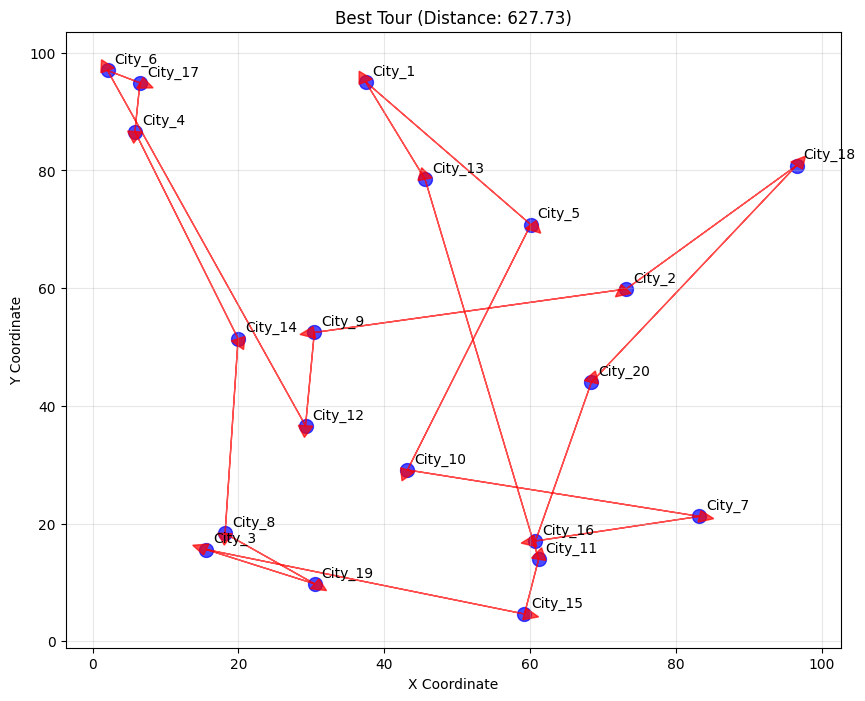

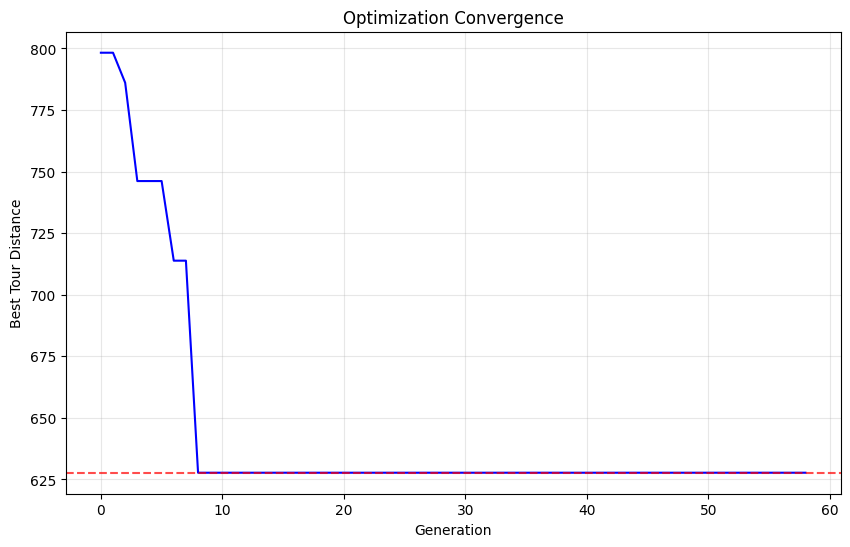

In [10]:
def tsp_objective(tour, data):
    """Objective function for TSP - minimize total distance."""
    distance_matrix = data['distance_matrix']
    
    # Calculate tour distance
    total_distance = calculate_tour_distance(tour, distance_matrix)
    
    # Return negative distance (for maximization in TrainSelPy)
    return -total_distance

# Create TrainSelPy data object
ts_data = make_data(M=np.eye(n_cities))  # Identity matrix as features (not used directly)
ts_data['distance_matrix'] = tsp_instance['distance_matrix']
ts_data['city_coords'] = tsp_instance['city_coords']
ts_data['city_names'] = tsp_instance['city_names']

# Set control parameters
control = train_sel_control(
    size="fixed",             # Fixed size selection
    niterations=200,          # Number of iterations
    minitbefstop=50,          # Minimum iterations before stopping
    nEliteSaved=10,           # Number of elite solutions to save
    nelite=5,                # Number of elite solutions
    npop=200,                 # Population size
    mutprob=0.5,              # Mutation probability
    mutintensity=0.3,         # Mutation intensity
    crossprob=0.8,            # Crossover probability
    crossintensity=0.5,       # Crossover intensity
    niterSANN=200,             # Simulated annealing iterations
    tempini=100.0,            # Initial temperature
    tempfin=0.1,              # Final temperature
    progress=True             # Show progress
)

# Run the optimization
print("Running single-objective TSP optimization...")
start_time = time.time()

result = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],  # All cities are candidates
    setsizes=[n_cities],                 # Select all cities
    settypes=["OS"],                     # Ordered set (order matters)
    stat=tsp_objective,                  # Objective function
    control=control,
    verbose=True
)

runtime = time.time() - start_time
print(f"Optimization completed in {runtime:.2f} seconds")

# Get best tour
best_tour = result.selected_indices[0]
best_distance = -result.fitness  # Convert back to positive distance

print(f"Best tour: {best_tour}")
print(f"Best tour distance: {best_distance:.2f}")
print(f"Improvement over random tour: {(random_distance - best_distance) / random_distance * 100:.2f}%")

# Visualize the best tour
plt.figure(figsize=(10, 8))
coords = tsp_instance['city_coords']

# Plot cities
plt.scatter(coords[:, 0], coords[:, 1], s=100, c='blue', alpha=0.7)

# Plot tour with directional arrows
for i in range(len(best_tour)):
    from_city = best_tour[i]
    to_city = best_tour[(i + 1) % len(best_tour)]
    
    # Draw arrow
    plt.arrow(coords[from_city, 0], coords[from_city, 1], 
              coords[to_city, 0] - coords[from_city, 0], 
              coords[to_city, 1] - coords[from_city, 1],
              head_width=2, head_length=2, fc='red', ec='red', alpha=0.7)

# Add city labels
for i, (x, y) in enumerate(coords):
    plt.annotate(tsp_instance['city_names'][i], (x, y), xytext=(5, 5), textcoords='offset points')

plt.title(f"Best Tour (Distance: {best_distance:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(alpha=0.3)
plt.show()

# Plot convergence curve
plt.figure(figsize=(10, 6))
plt.plot(-np.array(result.fitness_history), 'b-')
plt.axhline(y=best_distance, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Generation')
plt.ylabel('Best Tour Distance')
plt.title('Optimization Convergence')
plt.grid(alpha=0.3)
plt.show()

## 4. Multi-Objective TSP Optimization

Now let's solve the TSP using a multi-objective approach. We'll use two objectives:
1. Minimize the total distance
2. Minimize the maximum distance between any two consecutive cities in the tour (bottleneck)

This approach can help find tours that not only have good total distances but also avoid extremely long segments.

Running multi-objective TSP optimization...
Starting TrainSelPy optimization
Starting island model GA with 4 islands
Island optimizations completed, consolidating results...
Island model optimization completed, best fitness: -616.6695971035701
Optimization completed in 27.17 seconds
Final fitness: -616.6695971035701
Multi-objective optimization completed in 27.17 seconds
Found 1 solutions on the Pareto front

Best Solutions on the Pareto Front:

Best Total Distance Solution:
  Tour: [3, 5, 16, 8, 10, 7, 2, 18, 6, 14, 15, 19, 4, 17, 1, 9, 11, 13, 12, 0]
  Total Distance: 562.66
  Max Segment: 54.01

Best Max Segment Solution:
  Tour: [3, 5, 16, 8, 10, 7, 2, 18, 6, 14, 15, 19, 4, 17, 1, 9, 11, 13, 12, 0]
  Total Distance: 562.66
  Max Segment: 54.01

Balanced Solution:
  Tour: [3, 5, 16, 8, 10, 7, 2, 18, 6, 14, 15, 19, 4, 17, 1, 9, 11, 13, 12, 0]
  Total Distance: 562.66
  Max Segment: 54.01


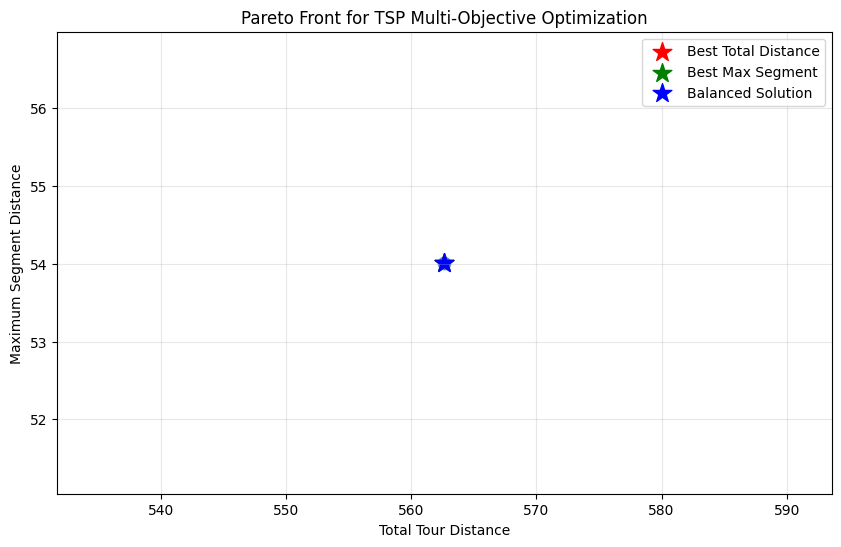

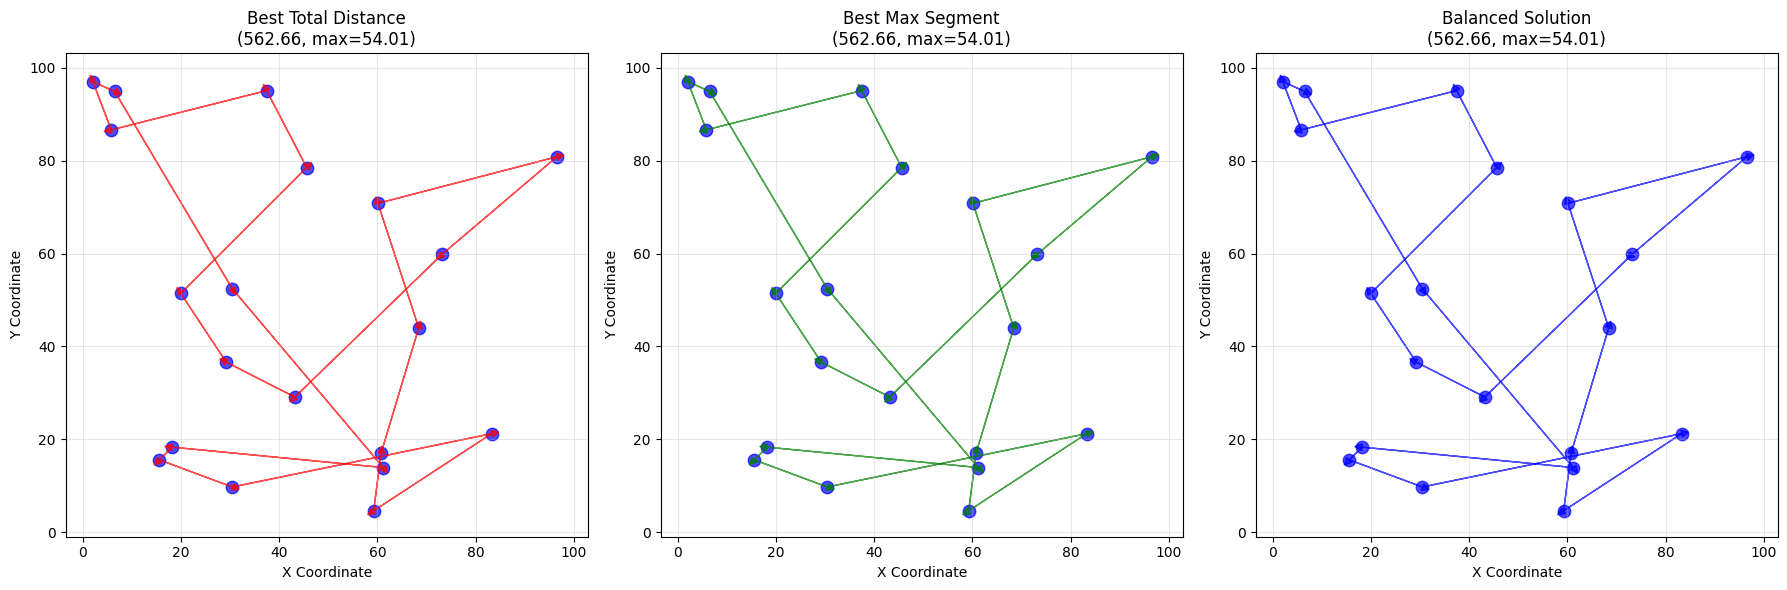

In [11]:
def tsp_multi_objectives(tour, data):
    """Multi-objective function for TSP.
    
    Objectives:
    1. Minimize total distance
    2. Minimize maximum distance between consecutive cities
    """
    distance_matrix = data['distance_matrix']
    tour = np.array(tour)
    
    # Calculate total distance (objective 1)
    total_distance = calculate_tour_distance(tour, distance_matrix)
    
    # Calculate maximum segment distance (objective 2)
    max_segment = 0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)]
        segment_distance = distance_matrix[from_city, to_city]
        max_segment = max(max_segment, segment_distance)
    
    # Return negative distances (for maximization in TrainSelPy)
    return [-total_distance, -max_segment]

# Set control parameters for multi-objective optimization
control_moo = train_sel_control(
    size="fixed",             # Fixed size selection
    niterations=200,          # Number of iterations
    minitbefstop=50,          # Minimum iterations before stopping
    nEliteSaved=30,           # Number of elite solutions to save (increased)
    nelite=100,               # Number of elite solutions (increased)
    npop=300,                 # Population size (increased)
    mutprob=0.2,              # Mutation probability
    mutintensity=0.3,         # Mutation intensity
    crossprob=0.8,            # Crossover probability
    crossintensity=0.5,       # Crossover intensity
    niterSANN=20,             # Simulated annealing iterations
    tempini=100.0,            # Initial temperature
    tempfin=0.1,              # Final temperature
    solution_diversity=True,  # Ensure diversity in Pareto front
    nislands=4,               # Use island model for better Pareto front
    niterIslands=50,          # Iterations per island
    progress=True             # Show progress
)

# Run the multi-objective optimization
print("Running multi-objective TSP optimization...")
start_time = time.time()

result_moo = train_sel(
    data=ts_data,
    candidates=[list(range(n_cities))],  # All cities are candidates
    setsizes=[n_cities],                 # Select all cities
    settypes=["OS"],                     # Ordered set (order matters)
    stat=tsp_multi_objectives,           # Multi-objective function
    n_stat=2,                            # Two objectives
    control=control_moo,
    verbose=True
)

runtime = time.time() - start_time
print(f"Multi-objective optimization completed in {runtime:.2f} seconds")

# Display Pareto front information
if result_moo.pareto_front:
    n_solutions = len(result_moo.pareto_front)
    print(f"Found {n_solutions} solutions on the Pareto front")
    
    # Convert objectives back to positive distances
    total_distances = [-obj[0] for obj in result_moo.pareto_front]
    max_segments = [-obj[1] for obj in result_moo.pareto_front]
    
    # Find specific solutions
    best_total_idx = np.argmin(total_distances)
    best_segment_idx = np.argmin(max_segments)
    
    # Calculate a balance score (normalized sum)
    normalized_total = (total_distances - np.min(total_distances)) / (np.max(total_distances) - np.min(total_distances) + 1e-10)
    normalized_segment = (max_segments - np.min(max_segments)) / (np.max(max_segments) - np.min(max_segments) + 1e-10)
    balance_scores = normalized_total + normalized_segment
    balanced_idx = np.argmin(balance_scores)
    
    # Print information about notable solutions
    print("\nBest Solutions on the Pareto Front:")
    
    # Best total distance solution
    best_total_tour = result_moo.pareto_solutions[best_total_idx]['selected_indices'][0]
    print(f"\nBest Total Distance Solution:")
    print(f"  Tour: {best_total_tour}")
    print(f"  Total Distance: {total_distances[best_total_idx]:.2f}")
    print(f"  Max Segment: {max_segments[best_total_idx]:.2f}")
    
    # Best max segment solution
    best_segment_tour = result_moo.pareto_solutions[best_segment_idx]['selected_indices'][0]
    print(f"\nBest Max Segment Solution:")
    print(f"  Tour: {best_segment_tour}")
    print(f"  Total Distance: {total_distances[best_segment_idx]:.2f}")
    print(f"  Max Segment: {max_segments[best_segment_idx]:.2f}")
    
    # Balanced solution
    balanced_tour = result_moo.pareto_solutions[balanced_idx]['selected_indices'][0]
    print(f"\nBalanced Solution:")
    print(f"  Tour: {balanced_tour}")
    print(f"  Total Distance: {total_distances[balanced_idx]:.2f}")
    print(f"  Max Segment: {max_segments[balanced_idx]:.2f}")
    
    # Plot Pareto front
    plt.figure(figsize=(10, 6))
    plt.scatter(total_distances, max_segments, s=80, alpha=0.7)
    
    # Highlight notable solutions
    plt.scatter(total_distances[best_total_idx], max_segments[best_total_idx], 
               s=200, c='red', marker='*', label='Best Total Distance')
    plt.scatter(total_distances[best_segment_idx], max_segments[best_segment_idx], 
               s=200, c='green', marker='*', label='Best Max Segment')
    plt.scatter(total_distances[balanced_idx], max_segments[balanced_idx], 
               s=200, c='blue', marker='*', label='Balanced Solution')
    
    plt.xlabel('Total Tour Distance')
    plt.ylabel('Maximum Segment Distance')
    plt.title('Pareto Front for TSP Multi-Objective Optimization')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
    
    # Visualize the three notable tours
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    tours = [best_total_tour, best_segment_tour, balanced_tour]
    titles = [f"Best Total Distance\n({total_distances[best_total_idx]:.2f}, max={max_segments[best_total_idx]:.2f})",
              f"Best Max Segment\n({total_distances[best_segment_idx]:.2f}, max={max_segments[best_segment_idx]:.2f})",
              f"Balanced Solution\n({total_distances[balanced_idx]:.2f}, max={max_segments[balanced_idx]:.2f})"]
    distance_matrix = tsp_instance['distance_matrix']
    coords = tsp_instance['city_coords']
    city_names = tsp_instance['city_names']

    for i, (ax, tour, title) in enumerate(zip(axes, tours, titles)):
        # Plot cities
        ax.scatter(coords[:, 0], coords[:, 1], s=80, c='blue', alpha=0.7)
        
        # Plot tour
        for j in range(len(tour)):
            from_city = tour[j]
            to_city = tour[(j + 1) % len(tour)]
            
            # Get segment distance
            segment_distance = distance_matrix[from_city, to_city]
            
            # Determine color based on distance (red for longer segments)
            if i == 0:  # Best total distance solution
                color = 'red'
                width = 1
            elif i == 1:  # Best max segment solution
                color = 'green'
                width = 1
            else:  # Balanced solution
                color = 'blue'
                width = 1
            
            # Draw arrow
            ax.arrow(coords[from_city, 0], coords[from_city, 1], 
                    coords[to_city, 0] - coords[from_city, 0], 
                    coords[to_city, 1] - coords[from_city, 1],
                    head_width=1.5, head_length=1.5, fc=color, ec=color, alpha=0.7, linewidth=width)
        
        # Add title
        ax.set_title(title)
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No Pareto front found.")

## 5. Comparison of Single-Objective and Multi-Objective Results

Let's compare the results from both optimization approaches.

Comparison of Single-Objective and Multi-Objective Results:

Single-Objective Solution:
  Total Distance: 627.73
  Max Segment: 66.42

Multi-Objective Balanced Solution:
  Total Distance: 562.66
  Max Segment: 54.01

Percent Differences:
  Total Distance: -10.37% better
  Max Segment: -18.68% better


/var/folders/8n/1l40cygn069cwys_v97vljmr0000gp/T/ipykernel_24222/23181264.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


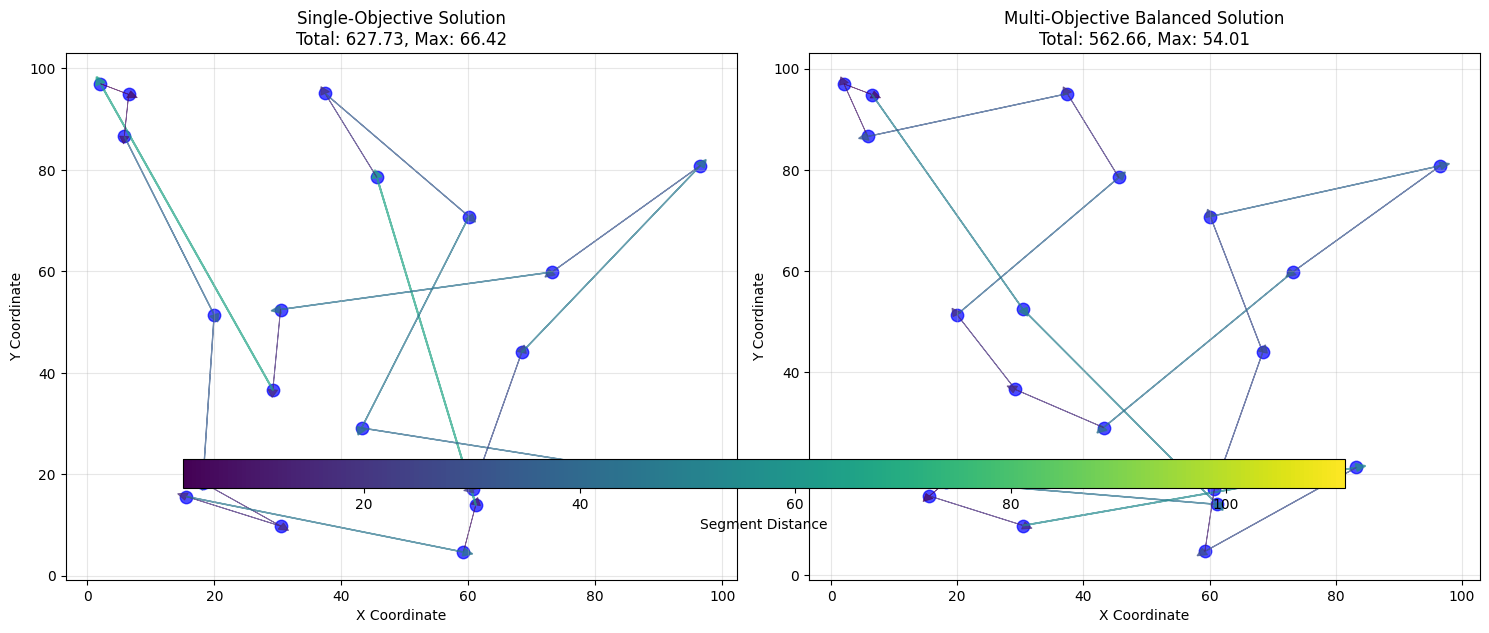

In [12]:
# Single-objective solution
single_obj_tour = best_tour
single_obj_total_distance = best_distance
single_obj_max_segment = 0

# Calculate max segment for single-objective solution
for i in range(len(single_obj_tour)):
    from_city = single_obj_tour[i]
    to_city = single_obj_tour[(i + 1) % len(single_obj_tour)]
    segment_distance = distance_matrix[from_city, to_city]
    single_obj_max_segment = max(single_obj_max_segment, segment_distance)

# Extract data for multi-objective solutions
if result_moo.pareto_front:
    # Extract data for multi-objective solutions
    moo_balanced_tour = balanced_tour
    moo_balanced_total_distance = total_distances[balanced_idx]
    moo_balanced_max_segment = max_segments[balanced_idx]
    
    # Compare single-objective and multi-objective solutions
    print("Comparison of Single-Objective and Multi-Objective Results:")
    print("\nSingle-Objective Solution:")
    print(f"  Total Distance: {single_obj_total_distance:.2f}")
    print(f"  Max Segment: {single_obj_max_segment:.2f}")
    
    print("\nMulti-Objective Balanced Solution:")
    print(f"  Total Distance: {moo_balanced_total_distance:.2f}")
    print(f"  Max Segment: {moo_balanced_max_segment:.2f}")
    
    # Calculate percent differences
    total_distance_diff = (moo_balanced_total_distance - single_obj_total_distance) / single_obj_total_distance * 100
    max_segment_diff = (moo_balanced_max_segment - single_obj_max_segment) / single_obj_max_segment * 100
    
    print("\nPercent Differences:")
    print(f"  Total Distance: {total_distance_diff:.2f}% {'worse' if total_distance_diff > 0 else 'better'}")
    print(f"  Max Segment: {max_segment_diff:.2f}% {'worse' if max_segment_diff > 0 else 'better'}")
    
    # Visual comparison of the two solutions
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Single-objective solution
    axes[0].scatter(coords[:, 0], coords[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(len(single_obj_tour)):
        from_city = single_obj_tour[i]
        to_city = single_obj_tour[(i + 1) % len(single_obj_tour)]
        segment_distance = distance_matrix[from_city, to_city]
        
        # Color intensity based on segment distance
        norm_distance = (segment_distance - np.min(distance_matrix[distance_matrix > 0])) / \
                        (np.max(distance_matrix) - np.min(distance_matrix[distance_matrix > 0]))
        
        # Draw arrow with color intensity based on segment distance
        axes[0].arrow(coords[from_city, 0], coords[from_city, 1], 
                     coords[to_city, 0] - coords[from_city, 0], 
                     coords[to_city, 1] - coords[from_city, 1],
                     head_width=1.5, head_length=1.5, 
                     fc=plt.cm.viridis(norm_distance), 
                     ec=plt.cm.viridis(norm_distance), 
                     alpha=0.7, linewidth=1.5*norm_distance+0.5)
    
    axes[0].set_title(f"Single-Objective Solution\nTotal: {single_obj_total_distance:.2f}, Max: {single_obj_max_segment:.2f}")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].grid(alpha=0.3)
    
    # Multi-objective balanced solution
    axes[1].scatter(coords[:, 0], coords[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(len(moo_balanced_tour)):
        from_city = moo_balanced_tour[i]
        to_city = moo_balanced_tour[(i + 1) % len(moo_balanced_tour)]
        segment_distance = distance_matrix[from_city, to_city]
        
        # Color intensity based on segment distance
        norm_distance = (segment_distance - np.min(distance_matrix[distance_matrix > 0])) / \
                        (np.max(distance_matrix) - np.min(distance_matrix[distance_matrix > 0]))
        
        # Draw arrow with color intensity based on segment distance
        axes[1].arrow(coords[from_city, 0], coords[from_city, 1], 
                     coords[to_city, 0] - coords[from_city, 0], 
                     coords[to_city, 1] - coords[from_city, 1],
                     head_width=1.5, head_length=1.5, 
                     fc=plt.cm.viridis(norm_distance), 
                     ec=plt.cm.viridis(norm_distance), 
                     alpha=0.7, linewidth=1.5*norm_distance+0.5)
    
    axes[1].set_title(f"Multi-Objective Balanced Solution\nTotal: {moo_balanced_total_distance:.2f}, Max: {moo_balanced_max_segment:.2f}")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].grid(alpha=0.3)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(distance_matrix[distance_matrix > 0]), 
                                                                       vmax=np.max(distance_matrix)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Segment Distance')
    
    plt.tight_layout()
    plt.show()

## 6. Conclusion

We've solved the Traveling Salesman Problem using two approaches with TrainSelPy:

1. **Single-Objective Optimization**: Focused solely on minimizing the total tour distance. This approach gives the shortest overall tour but may include some long individual segments.

2. **Multi-Objective Optimization**: Balanced two objectives - minimizing total distance and minimizing the maximum segment length. This approach provides more options with different trade-offs between total distance and maximum segment length.

The multi-objective approach offers more flexibility for real-world scenarios where multiple factors need to be considered. For example, in a real delivery route, minimizing the longest individual segment might be important for fuel planning or driver scheduling, even if it slightly increases the total distance.

TrainSelPy's genetic algorithm capabilities prove effective for both approaches, demonstrating its versatility in solving complex optimization problems.